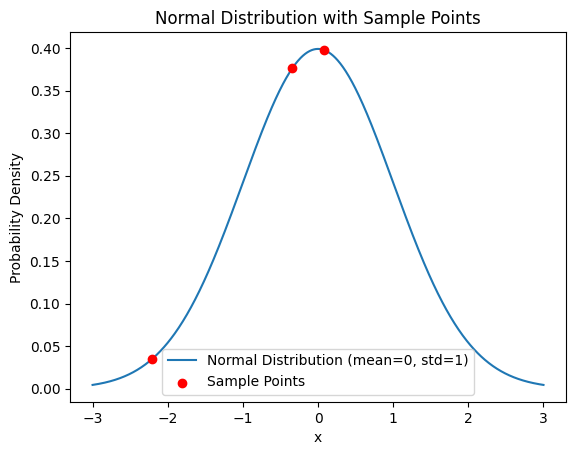

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters for the normal distribution
mu = 0  # Mean
sigma = 1  # Standard Deviation

# Generate x-values over a range of ±3σ from the mean
x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 1000)

# Calculate the corresponding PDF values
y = norm.pdf(x, mu, sigma)

# Draw three sample points from the same normal distribution
sample_points = np.random.normal(mu, sigma, 3)

# Calculate the PDF at each of the sample points (to plot them correctly on the curve)
sample_pdf_values = norm.pdf(sample_points, mu, sigma)

# Plot the normal distribution
plt.plot(x, y, label="Normal Distribution (mean=0, std=1)")

# Plot the sample points on the curve
plt.scatter(
    sample_points, sample_pdf_values, color="red", zorder=5, label="Sample Points"
)

# Labeling the axes and adding a title
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.title("Normal Distribution with Sample Points")

# Show legend
plt.legend()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize


def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    """
    Proposes the next sampling point by optimizing the acquisition function.

    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    """
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None

    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)

    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method="L-BFGS-B")
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x

    return min_x


def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    """
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.

    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.

    Returns:
        Expected improvements at points X.
    """
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    # See also section 2.4 in [1]
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide="warn"):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        Z[sigma <= 0.0] = 0.0
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma <= 0.0] = 0.0

    return ei


def plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X, return_std=True)
    plt.fill_between(
        X.ravel(), mu.ravel() + 1.96 * std, mu.ravel() - 1.96 * std, alpha=0.1
    )
    plt.plot(X, Y, "y--", lw=1, label="Noise-free objective")
    plt.plot(X, mu, "b-", lw=1, label="Surrogate function")
    plt.plot(X_sample, Y_sample, "kx", mew=3, label="Noisy samples")
    if X_next:
        plt.axvline(x=X_next, ls="--", c="k", lw=1)
    if show_legend:
        plt.legend()


def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, "r-", lw=1, label="Acquisition function")
    plt.axvline(x=X_next, ls="--", c="k", lw=1, label="Next sampling location")
    if show_legend:
        plt.legend()


def plot_convergence(X_sample, Y_sample, n_init=2):
    plt.figure(figsize=(12, 3))

    x = X_sample[n_init:].ravel()
    y = Y_sample[n_init:].ravel()
    r = range(1, len(x) + 1)

    x_neighbor_dist = [np.abs(a - b) for a, b in zip(x, x[1:])]
    y_max_watermark = np.maximum.accumulate(y)

    plt.subplot(1, 2, 1)
    plt.plot(r[1:], x_neighbor_dist, "bo-")
    plt.xlabel("Iteration")
    plt.ylabel("Distance")
    plt.title("Distance between consecutive x's")

    plt.subplot(1, 2, 2)
    plt.plot(r, y_max_watermark, "ro-")
    plt.xlabel("Iteration")
    plt.ylabel("Best Y")
    plt.title("Value of best selected sample")

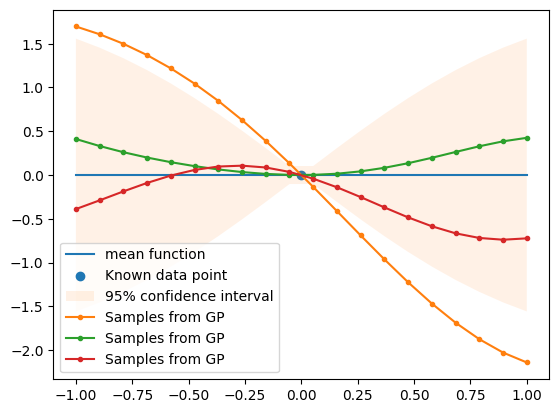

In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor

gpr = GaussianProcessRegressor()
gpr.fit([[0]], [0])
t = np.linspace(-1, 1, 20)
mu, std = gpr.predict(t.reshape(-1, 1), return_std=True)
plt.plot(t, mu, label="mean function")
plt.scatter(0, 0, label="Known data point")
plt.fill_between(
    t,
    mu.ravel() + 1.96 * std,
    mu.ravel() - 1.96 * std,
    alpha=0.1,
    label="95% confidence interval",
)
y = gpr.sample_y(t.reshape(-1, 1), 3, random_state=np.random.randint(0, 1000))
plt.plot(t, y, marker=".", label="Samples from GP")
plt.legend()

In [11]:
import numpy as np

%matplotlib inline

bounds = np.array([[-1.0, 2.0]])
noise = 0.2


def f(X, noise=noise):
    return -np.sin(3 * X) - X**2 + 0.7 * X + noise * np.random.randn(*X.shape)


X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)

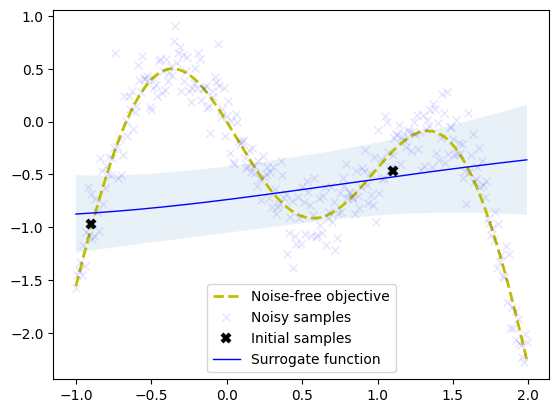

In [20]:
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X
Y = f(X, 0)

# Gaussian process with Matern kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
guessed_noise = 0.2  # change noise estimation which smooths the surrogate function
gpr = GaussianProcessRegressor(
    kernel=m52, alpha=guessed_noise**2, n_restarts_optimizer=10
)
gpr.fit(X_init, Y_init)

# Plot optimization objective with noise level
plt.plot(X, Y, "y--", lw=2, label="Noise-free objective")
plt.plot(X, f(X), "bx", lw=1, alpha=0.1, label="Noisy samples")
plt.plot(X_init, Y_init, "kx", mew=3, label="Initial samples")
mu, std = gpr.predict(X, return_std=True)
plt.fill_between(X.ravel(), mu.ravel() + 1.96 * std, mu.ravel() - 1.96 * std, alpha=0.1)
plt.plot(X, mu, "b-", lw=1, label="Surrogate function")
plt.legend()

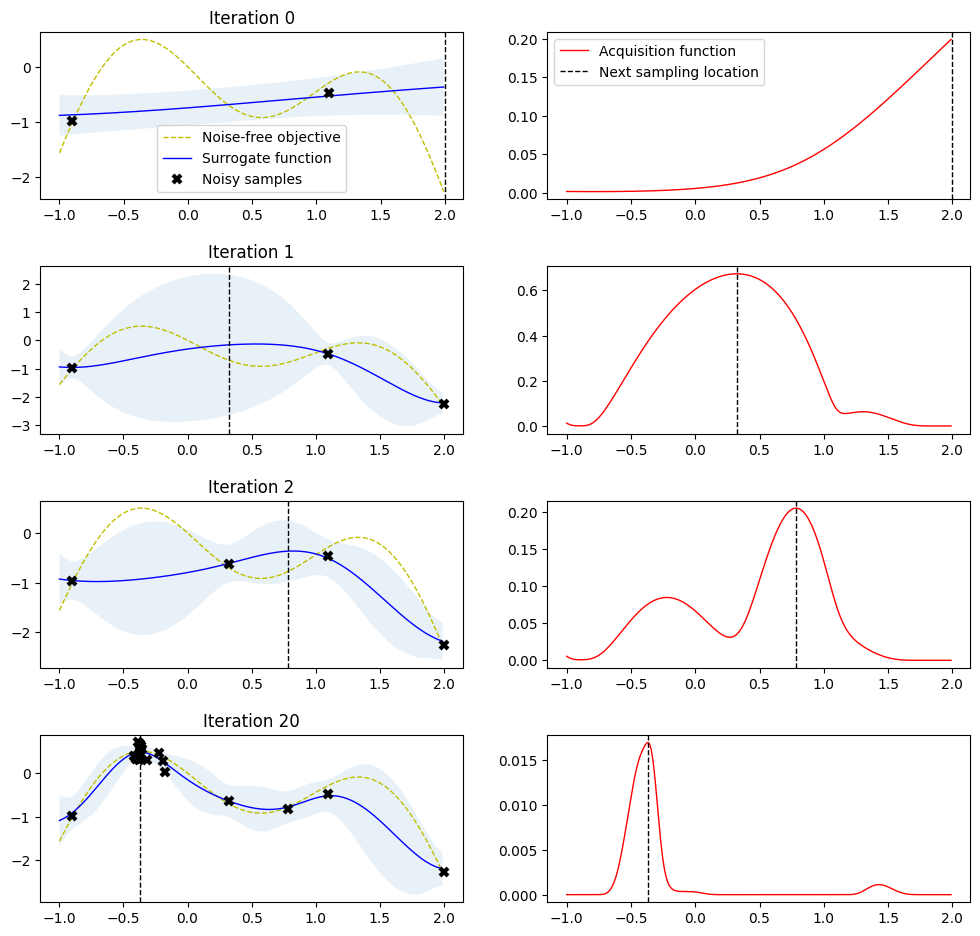

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

# Gaussian process with Matern kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
guessed_noise = 0.2  # change noise estimation which smooths the surrogate function
gpr = GaussianProcessRegressor(
    kernel=m52, alpha=guessed_noise**2, n_restarts_optimizer=10
)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 20

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

# modify exploration/exploitation trade-off parameter here
xi = 0.01  # high xi -> high exploration, low xi -> high exploitation
expected_improvement2 = lambda a, b, c, d: expected_improvement(a, b, c, d, xi)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement2, X_sample, Y_sample, gpr, bounds)

    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)

    # Plot samples, surrogate function, noise-free objective and next sampling location
    if i == 0 or i == 1 or i == 2 or i == 19:
        if i == 19:
            i = 3
        plt.subplot(n_iter, 2, 2 * i + 1)
        plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i == 0)
        plt.title(f"Iteration {i if i != 3 else 20}")

        plt.subplot(n_iter, 2, 2 * i + 2)
        plot_acquisition(
            X,
            expected_improvement2(X, X_sample, Y_sample, gpr),
            X_next,
            show_legend=i == 0,
        )

    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

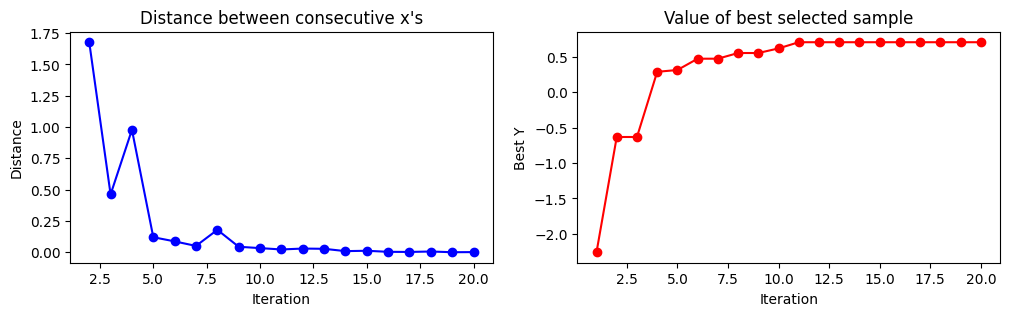

In [14]:
plot_convergence(X_sample, Y_sample)